In [1]:
import pandas as pd
import numpy as np
import shap
import pickle
import json
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split, KFold
from sklearn.impute import SimpleImputer
from sklearn.utils import shuffle
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import classification_report, multilabel_confusion_matrix, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# load dataset
df = pd.read_csv('../../../../datasets/atis_dataset_preprocessed.csv', sep=';')

In [3]:
# define label columns
label_columns = ['ILS', 'RNAV', 'RNP', 'VISUAL']

# list of all airport-dependent features to drop
airport_dependent = ['airport_icao', 'runway_designator_number', 'runway_designator_side', 'runway_ils_category']

# define features and targets
X = df.drop(columns=label_columns + airport_dependent)

# one-hot encode features that are categorical
X = pd.get_dummies(X, columns=['weather_phenomenon', 'rvr_tendency'])

In [4]:
y = df[label_columns]

In [5]:
# concat X and y for deduplication
combined = pd.concat([X, y], axis=1)

# drop duplicates
combined_no_dupes = combined.drop_duplicates()

# split back into features and labels
X = combined_no_dupes.drop(columns=label_columns)
y = combined_no_dupes[label_columns]

In [6]:
# train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

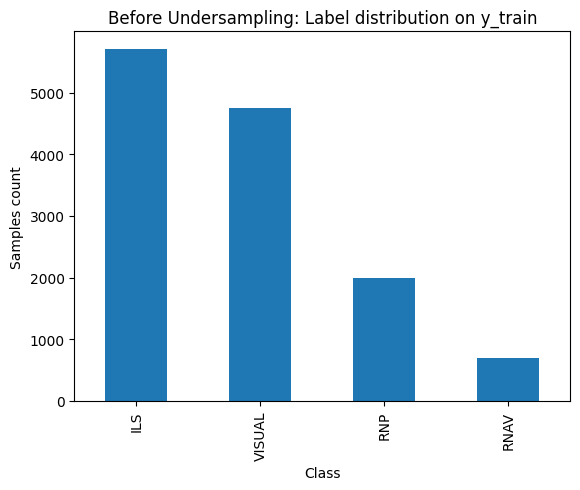

Label distribution:
 ILS       5705
VISUAL    4745
RNP       1992
RNAV       694
dtype: int64


In [7]:
# check for label distribution
label_counts = y_train.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('Before Undersampling: Label distribution on y_train')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [8]:
# Combine X and y for downsampling
train_combined = pd.concat([X_train, y_train], axis=1)

# Find min label count in training data
min_count = y_train.sum().min()

# Sample equal number of rows for each label
balanced_parts = []

for label in label_columns:
    subset = train_combined[train_combined[label] == 1]
    sampled = subset.sample(n=min_count, random_state=42)
    balanced_parts.append(sampled)

# Merge, shuffle, split back to X/y
balanced_train = pd.concat(balanced_parts).drop_duplicates()
balanced_train = shuffle(balanced_train, random_state=42)

X_train_bal = balanced_train[X.columns]
y_train_bal = balanced_train[label_columns]

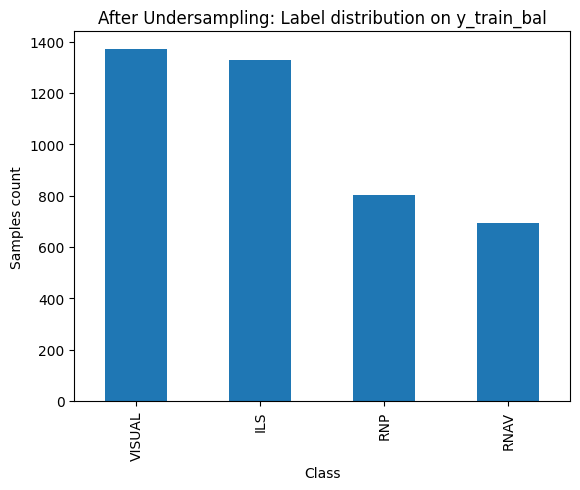

Label distribution:
 VISUAL    1371
ILS       1330
RNP        804
RNAV       694
dtype: int64


In [9]:
# check for label distribution after undersampling
label_counts = y_train_bal.sum().sort_values(ascending=False)
label_counts.plot(kind='bar')
plt.title('After Undersampling: Label distribution on y_train_bal')
plt.xlabel('Class')
plt.ylabel('Samples count')
plt.show()

print("Label distribution:\n", label_counts)

In [10]:
# impute
imputer = SimpleImputer(strategy='mean')
X_train = imputer.fit_transform(X_train_bal)
X_test = imputer.transform(X_test)

In [11]:
# feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# build and train multi-label model + hyperparameter tuning
def objective(trial):
    # Each hyperparameter is sampled by Optuna using Bayesian optimization
    C = trial.suggest_float('C', 0.01, 100)
    # kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly'])
    gamma = trial.suggest_categorical('gamma', ['scale', 'auto'])

    # if kernel == 'poly':
    #     degree = trial.suggest_int('degree', 2, 4)
    # else:
    #     degree = 3  # default poly degree

    # Create base model
    svc = SVC(
        C=C,
        kernel='linear',
        degree=3,
        gamma=gamma,
        probability=True,
        class_weight='balanced',
        random_state=42
    )
    
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    f1_scores = []
    
    for train_idx, val_idx in kf.split(X_train_scaled):
        X_train_fold, X_val_fold = X_train_scaled[train_idx], X_train_scaled[val_idx]
        y_train_fold, y_val_fold = y_train_bal.iloc[train_idx], y_train_bal.iloc[val_idx]

        model = OneVsRestClassifier(svc, n_jobs=1)
        model.fit(X_train_fold, y_train_fold)
        y_pred = model.predict(X_val_fold)
        f1 = f1_score(y_val_fold, y_pred, average='macro')
        f1_scores.append(f1)
    
    return sum(f1_scores) / len(f1_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20, n_jobs=4)

[I 2025-06-16 09:38:07,034] A new study created in memory with name: no-name-bfa0f50d-3795-4400-b2a8-1e2e135d0c78


[I 2025-06-16 10:06:43,390] Trial 0 finished with value: 0.5139581892490241 and parameters: {'C': 32.22721845716587, 'gamma': 'auto'}. Best is trial 0 with value: 0.5139581892490241.


[I 2025-06-16 10:20:14,998] Trial 4 finished with value: 0.5140820102374353 and parameters: {'C': 20.00522267323228, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 10:28:22,928] Trial 3 finished with value: 0.5140171745122222 and parameters: {'C': 46.38796333792464, 'gamma': 'auto'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 10:47:08,576] Trial 2 finished with value: 0.5139581892490241 and parameters: {'C': 58.71967843371787, 'gamma': 'auto'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 10:55:36,830] Trial 1 finished with value: 0.5140171745122222 and parameters: {'C': 67.77562668975041, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 10:56:34,308] Trial 8 finished with value: 0.51390859710961 and parameters: {'C': 5.936989093526655, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 11:02:27,982] Trial 5 finished with value: 0.5139581892490241 and parameters: {'C': 40.12084670502358, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 11:03:21,182] Trial 6 finished with value: 0.5139581892490241 and parameters: {'C': 36.31136869995399, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 11:36:53,758] Trial 7 finished with value: 0.5139581892490241 and parameters: {'C': 47.6808481376312, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 11:37:41,392] Trial 10 finished with value: 0.5140230249742372 and parameters: {'C': 36.55030963371751, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 11:53:38,714] Trial 9 finished with value: 0.5139581892490241 and parameters: {'C': 49.836352491710265, 'gamma': 'auto'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 12:52:08,603] Trial 11 finished with value: 0.5140171745122222 and parameters: {'C': 88.25148886317636, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:00:00,115] Trial 15 finished with value: 0.5139581892490241 and parameters: {'C': 16.04762017917411, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:13:44,431] Trial 16 finished with value: 0.5139581892490241 and parameters: {'C': 22.132489287957196, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:14:06,736] Trial 17 finished with value: 0.5139588061976073 and parameters: {'C': 0.7619560292917988, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:16:00,658] Trial 12 finished with value: 0.5139581892490241 and parameters: {'C': 81.03618498636672, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:28:37,141] Trial 13 finished with value: 0.5140171745122222 and parameters: {'C': 91.95408717482204, 'gamma': 'auto'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:29:22,031] Trial 18 finished with value: 0.5140171745122222 and parameters: {'C': 22.77095032407562, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:33:22,588] Trial 19 finished with value: 0.5139581892490241 and parameters: {'C': 22.809428194735453, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


[I 2025-06-16 13:42:19,715] Trial 14 finished with value: 0.5140171745122222 and parameters: {'C': 90.37122987066898, 'gamma': 'scale'}. Best is trial 4 with value: 0.5140820102374353.


In [13]:
print(f"Best params:, {study.best_trial.params}")
print(f"Best F1:, {study.best_value}")

Best params:, {'C': 20.00522267323228, 'gamma': 'scale'}
Best F1:, 0.5140820102374353


In [14]:
# save all trials log
df = study.trials_dataframe()
df.to_csv("../../optuna_trials/svm_ovr_with_airport_feats_optuna_trials.csv", index=False)

In [15]:
# save trained best model
best_params = study.best_trial.params
best_model = OneVsRestClassifier(SVC(
    **best_params,
    kernel='linear',
    degree=3,
    probability=True,
    class_weight='balanced',
    random_state=42
))

best_model.fit(X_train_scaled, y_train_bal)

with open("../../trained_models/model-svm-ovr-BYS-linear-with_airport_feats.pkl", "wb") as f:
    pickle.dump(best_model, f)

In [16]:
# features in order
feature_order = list(X.columns)

# save to json
with open("../../feature_order/feature_order_svm_ovr_BYS_linear_with_airport_feats.json", "w") as f:
    json.dump(feature_order, f)

In [17]:
# predict and evaluate
y_pred = best_model.predict(X_test_scaled)
empty_mask = y_pred.sum(axis=1) == 0
no_predictions = np.sum(empty_mask)
print(f"Samples with no predicted labels: {no_predictions} out of {len(y_pred)}")
print(X_test[empty_mask])
print(classification_report(y_test, y_pred, target_names=label_columns, zero_division=0))

Samples with no predicted labels: 31 out of 2247
[[10.  6.  0. ...  1.  0.  0.]
 [10. 16.  0. ...  1.  0.  0.]
 [10. 13.  0. ...  1.  0.  0.]
 ...
 [10.  7.  0. ...  1.  0.  0.]
 [10.  6.  0. ...  1.  0.  0.]
 [10.  7.  0. ...  1.  0.  0.]]
              precision    recall  f1-score   support

         ILS       0.80      0.38      0.52      1449
        RNAV       0.10      0.65      0.17       134
         RNP       0.30      0.72      0.42       500
      VISUAL       0.75      0.44      0.55      1224

   micro avg       0.44      0.46      0.45      3307
   macro avg       0.49      0.55      0.42      3307
weighted avg       0.68      0.46      0.50      3307
 samples avg       0.43      0.47      0.42      3307



C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


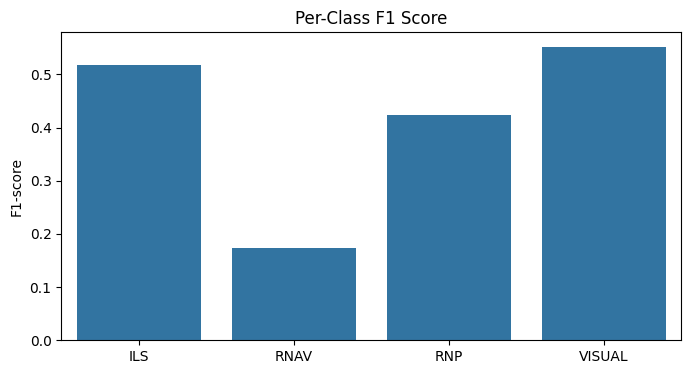

In [18]:
# per-class F1-score bar chart
report = classification_report(y_test, y_pred, output_dict=True)
f1_scores = [report[str(i)]['f1-score'] for i in range(len(label_columns))]
plt.figure(figsize=(8,4))
sns.barplot(x=label_columns, y=f1_scores)
plt.title("Per-Class F1 Score")
plt.ylabel("F1-score")
plt.show()

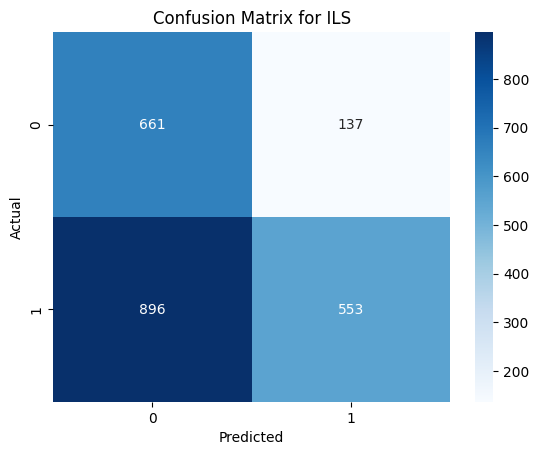

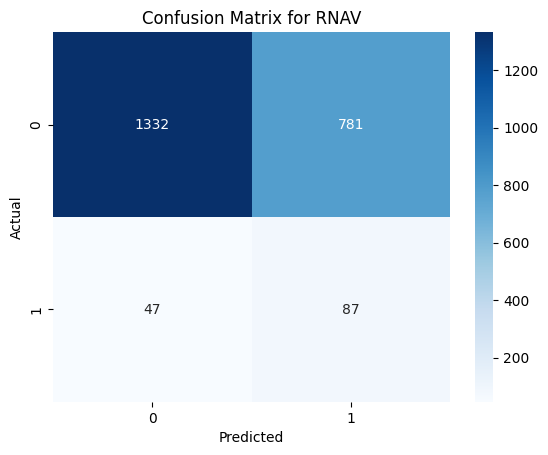

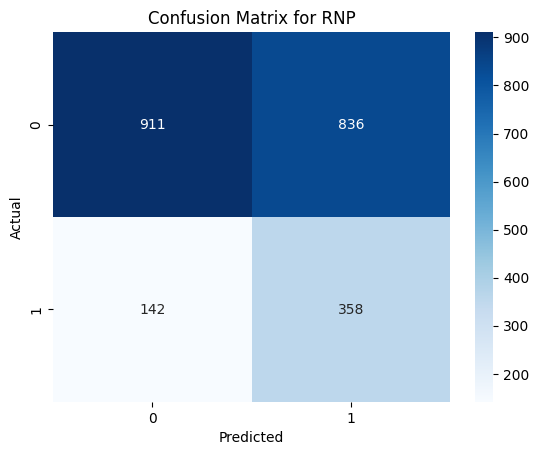

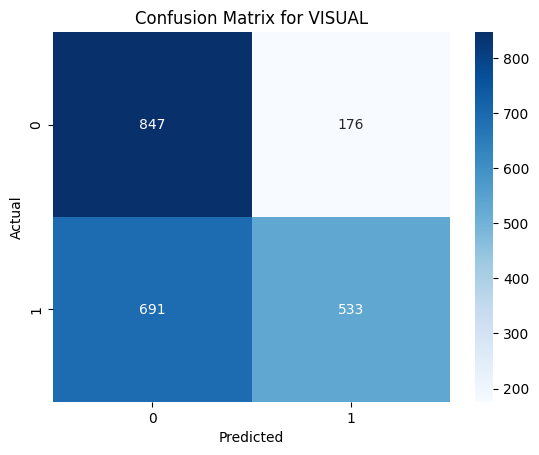

In [19]:
# confusion matrix per label
cm = multilabel_confusion_matrix(y_test, y_pred)
for i, label in enumerate(label_columns):
    plt.figure()
    sns.heatmap(cm[i], annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix for {label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig(f"../../visualizations/confusion-matrix/with_airport_features-OVR/{label}-with_airport_features-ovr-BYS-linear.png")
    plt.show()

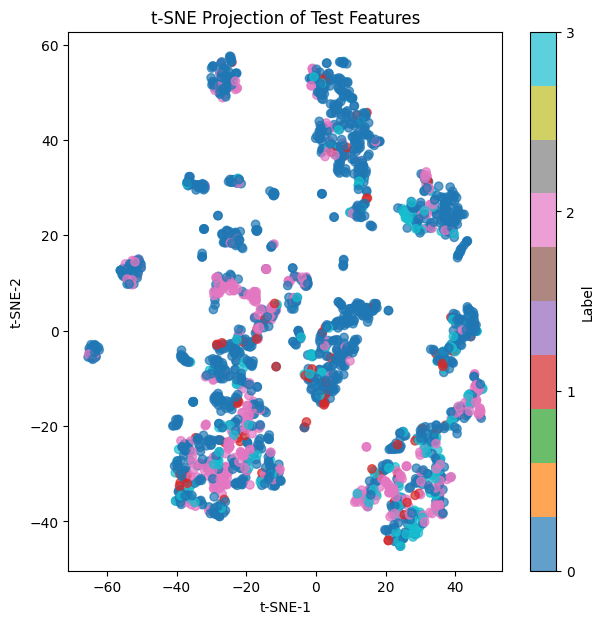

In [20]:
# t-SNE projection
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
X_proj = tsne.fit_transform(X_test_scaled)
dominant_label = np.argmax(y_test.values, axis=1)
plt.figure(figsize=(7,7))
plt.scatter(X_proj[:,0], X_proj[:,1], c=dominant_label, cmap='tab10', alpha=0.7)
plt.title('t-SNE Projection of Test Features')
plt.xlabel('t-SNE-1')
plt.ylabel('t-SNE-2')
plt.colorbar(ticks=range(len(label_columns)), label='Label')
plt.savefig("../../visualizations/t-SNE/with_airport_features-ovr-BYS-linear.png")
plt.show()

SHAP summary plot for ILS


  0%|          | 0/50 [00:00<?, ?it/s]

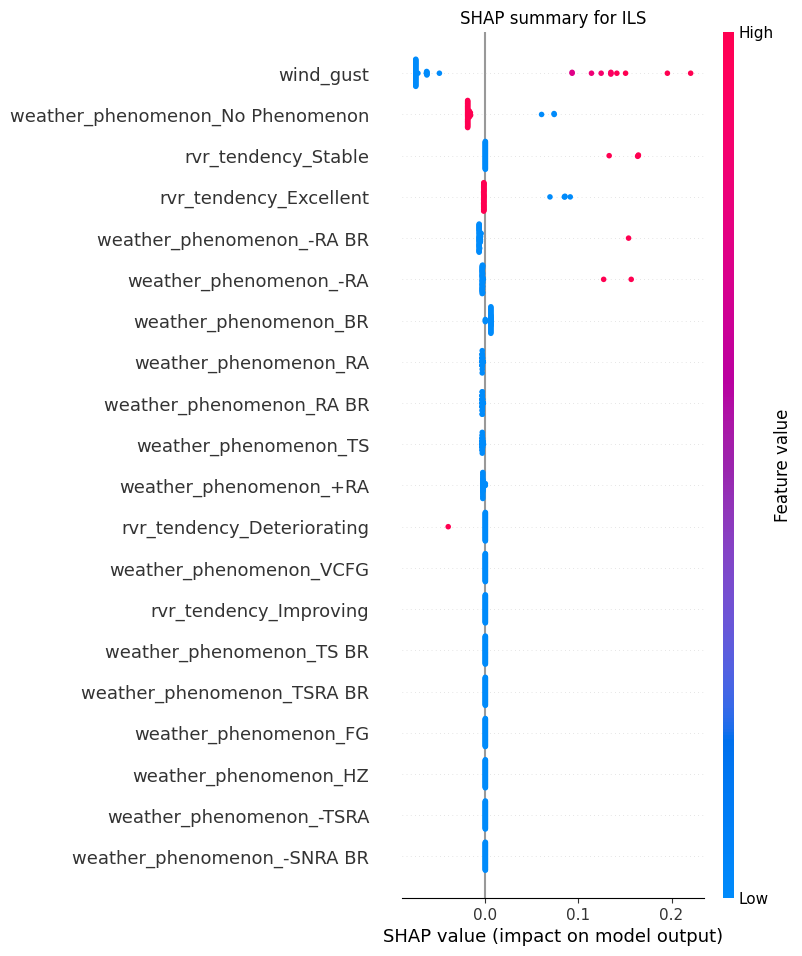

SHAP summary plot for RNAV


  0%|          | 0/50 [00:00<?, ?it/s]

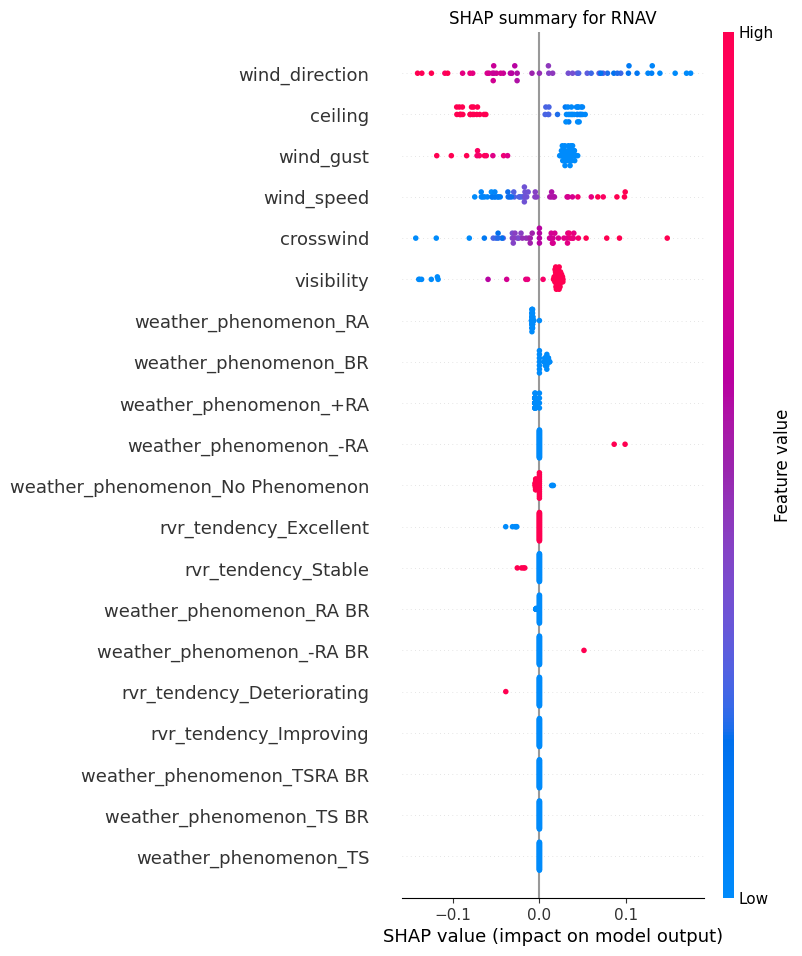

SHAP summary plot for RNP


  0%|          | 0/50 [00:00<?, ?it/s]

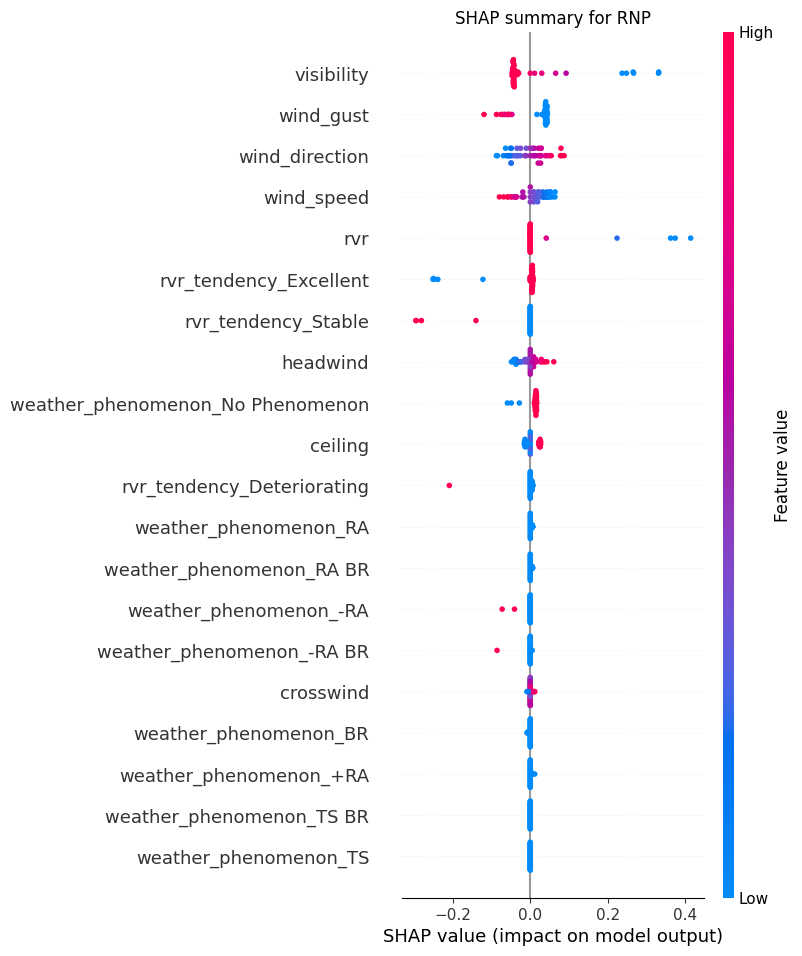

SHAP summary plot for VISUAL


  0%|          | 0/50 [00:00<?, ?it/s]

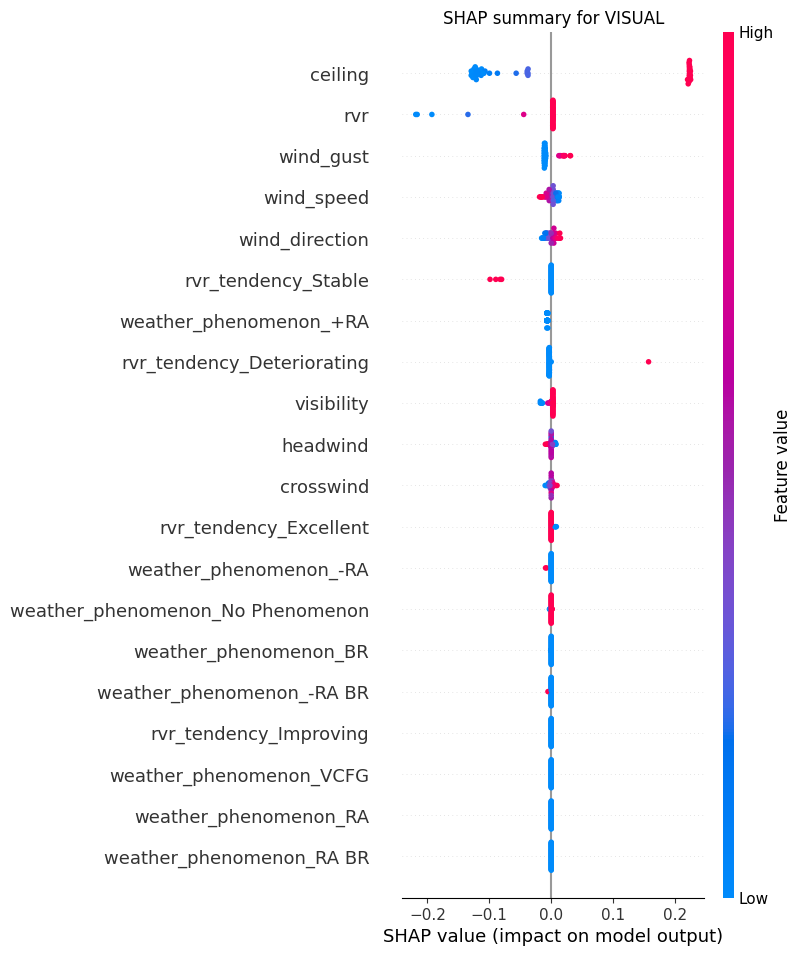

In [21]:
X_train_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

for idx, label in enumerate(label_columns):
    print(f"SHAP summary plot for {label}")
    
    clf = best_model.estimators_[idx]
    background = shap.sample(X_train_df, 50, random_state=42)
    X_sample = shap.sample(X_test_df, 50, random_state=42)

    # Fix: only use probability of positive class
    explainer = shap.KernelExplainer(lambda X: clf.predict_proba(X)[:, 1], background)
    shap_values = explainer.shap_values(X_sample)

    shap.summary_plot(shap_values, X_sample, show=False)
    plt.title(f"SHAP summary for {label}")
    plt.savefig(f"../../visualizations/SHAP/with_airport_features-OVR/{label}-with_airport_features-ovr-BYS-linear.png")
    plt.show()

In [22]:
# Buat versi DataFrame dari scaled test set (agar bisa dibaca dan di-display)
X_test_df = pd.DataFrame(X_test_scaled, columns=X.columns)

# Evaluasi false predictions
for i, label in enumerate(label_columns):
    print(f"\n====== {label} ======")

    # Ambil indeks FP dan FN
    false_positives = np.where((y_test[label].values == 0) & (y_pred[:, i] == 1))[0]
    false_negatives = np.where((y_test[label].values == 1) & (y_pred[:, i] == 0))[0]

    # Ambil data FP
    print(f"\n{label} False Positives (max 5):")
    fp_idx = false_positives[:5]
    df_fp = X_test_df.iloc[fp_idx].copy()
    df_fp['y_true'] = y_test.iloc[fp_idx][label].values
    df_fp['y_pred'] = y_pred[fp_idx, i]
    display(df_fp)

    # Ambil data FN
    print(f"{label} False Negatives (max 5):")
    fn_idx = false_negatives[:5]
    df_fn = X_test_df.iloc[fn_idx].copy()
    df_fn['y_true'] = y_test.iloc[fn_idx][label].values
    df_fn['y_pred'] = y_pred[fn_idx, i]
    display(df_fn)



====== ILS ======

ILS False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
9,0.383793,1.891541,2.044151,0.577255,0.104281,2.059801,0.082439,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
15,0.383793,0.316104,1.264694,-0.924294,0.104281,-1.835726,-1.463592,-0.617842,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
51,0.383793,-1.062403,-0.489084,0.791762,0.104281,-0.357016,0.310275,-0.771447,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
55,0.383793,0.709963,1.654423,0.040988,0.104281,-0.261615,-1.902991,-0.310634,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
67,0.383793,2.088471,2.239016,0.684508,0.104281,2.171102,0.652029,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1


ILS False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
1,0.383793,-0.471614,-0.489084,-0.495280,0.104281,-1.819826,-0.649892,-0.641474,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
2,0.383793,-0.865474,-0.489084,-0.602533,0.104281,-0.563718,-0.617344,-0.641474,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
6,0.383793,-0.471614,-0.489084,-0.709787,0.104281,-2.010628,-0.308137,-0.665105,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
7,-3.706890,0.709963,-0.489084,0.040988,0.104281,0.835492,-0.975372,-0.863609,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
8,-4.601726,1.103823,-0.489084,-0.388026,-11.129890,-0.150315,-2.212197,-0.894330,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,11.432410,-6.978403,-0.027566,-0.10913,1,0



====== RNAV ======

RNAV False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
1,0.383793,-0.471614,-0.489084,-0.495280,0.104281,-1.819826,-0.649892,-0.641474,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
2,0.383793,-0.865474,-0.489084,-0.602533,0.104281,-0.563718,-0.617344,-0.641474,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
3,0.383793,1.497682,-0.489084,0.577255,0.104281,1.694098,-0.405781,-0.863609,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
6,0.383793,-0.471614,-0.489084,-0.709787,0.104281,-2.010628,-0.308137,-0.665105,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
10,0.383793,0.906893,-0.489084,-1.246054,0.104281,0.962693,1.221620,-0.799804,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1


RNAV False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
15,0.383793,0.316104,1.264694,-0.924294,0.104281,-1.835726,-1.463592,-0.617842,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
107,-1.661548,0.709963,1.849287,-0.280773,0.104281,0.072287,-1.756525,-0.839978,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
231,0.383793,0.513034,-0.489084,0.040988,0.104281,0.692391,-0.894002,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
269,0.383793,-0.668544,-0.489084,-1.675068,0.104281,-0.627318,-0.828906,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
336,0.383793,-0.471614,-0.489084,0.791762,0.104281,-0.102614,0.814770,-0.452423,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0



====== RNP ======

RNP False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
2,0.383793,-0.865474,-0.489084,-0.602533,0.104281,-0.563718,-0.617344,-0.641474,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
4,0.383793,-1.062403,-0.489084,0.684508,0.104281,-0.404716,-0.243041,-0.724184,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
7,-3.706890,0.709963,-0.489084,0.040988,0.104281,0.835492,-0.975372,-0.863609,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
8,-4.601726,1.103823,-0.489084,-0.388026,-11.129890,-0.150315,-2.212197,-0.894330,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,11.432410,-6.978403,-0.027566,-0.10913,0,1
12,0.383793,0.709963,-0.489084,0.684508,0.104281,1.073994,-0.291863,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1


RNP False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
9,0.383793,1.891541,2.044151,0.577255,0.104281,2.059801,0.082439,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
23,0.383793,-0.471614,-0.489084,-1.031547,0.104281,0.008687,0.652029,-0.825799,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
32,0.383793,-0.668544,-0.489084,-2.007553,0.104281,-1.422324,0.928688,-0.863609,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
51,0.383793,-1.062403,-0.489084,0.791762,0.104281,-0.357016,0.310275,-0.771447,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
67,0.383793,2.088471,2.239016,0.684508,0.104281,2.171102,0.652029,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0



====== VISUAL ======

VISUAL False Positives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
16,0.383793,-0.274685,-0.489084,0.148241,0.104281,-0.325216,-1.040468,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
26,0.383793,-1.062403,-0.489084,-0.817040,0.104281,-1.581325,-0.031479,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
45,0.383793,1.497682,2.239016,1.864296,0.104281,1.105794,-1.691429,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
77,0.383793,0.513034,1.167262,-1.889575,0.104281,0.692391,-0.894002,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1
86,0.383793,-0.668544,-0.489084,-1.675068,0.104281,-0.627318,-0.828906,1.461697,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,0,1


VISUAL False Negatives (max 5):


,visibility,wind_speed,wind_gust,wind_direction,rvr,headwind,crosswind,ceiling,weather_phenomenon_+RA,weather_phenomenon_+RA BR,...,weather_phenomenon_TS,weather_phenomenon_TS BR,weather_phenomenon_TSRA BR,weather_phenomenon_VCFG,rvr_tendency_Deteriorating,rvr_tendency_Excellent,rvr_tendency_Improving,rvr_tendency_Stable,y_true,y_pred
2,0.383793,-0.865474,-0.489084,-0.602533,0.104281,-0.563718,-0.617344,-0.641474,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
4,0.383793,-1.062403,-0.489084,0.684508,0.104281,-0.404716,-0.243041,-0.724184,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
13,0.383793,3.860838,3.505634,1.435283,0.104281,3.586212,0.896140,-0.759631,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
14,0.383793,-0.274685,-0.489084,-0.495280,0.104281,-0.325216,1.205346,-0.799804,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
17,-0.638878,-0.077755,-0.489084,0.791762,0.104281,0.390289,0.586933,-0.759631,-0.033768,-0.033768,...,-0.04361,-0.019488,-0.033768,-0.055195,-0.087471,0.143299,-0.027566,-0.10913,1,0
